## 참고 :  https://velog.io/@vector13/Food101-데이터셋을-이용한-음식-이미지-분류기-만들기

### 0. 기본 환경 설정 

In [1]:
from shutil import copy
from collections import defaultdict
import scipy
import numpy as np
import matplotlib.pyplot as plt

import random
import cv2
import glob
from PIL import Image, ImageEnhance
import PIL.ImageOps

import torch
import torchvision
from torch import nn


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Theano(th)와 Tensorflow(tf) 모두와 호환이 되는 Keras 모듈을 작성
import keras.backend as K
from keras import regularizers
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator # 데이터 전처리
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import SGD

from keras_preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())


2.10.0
/device:GPU:0
Metal device set to: Apple M1


### 1. food101 다운 소스 : https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/
* 주의 : food101 데이터 다운받은 후 train/test 나눌 때 한번만 코드 실행

In [ ]:
def prepare_data(filepath, src,dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
    #print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
        copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!",classes_images.keys())


# 본인 환경에 맞게 food101 들어있는 디렉토리 설정하기
prepare_data('/Volumes/T7/food-101/meta/train.txt', '/Volumes/T7/food-101/images', '/Volumes/T7/food-101/train')
prepare_data('/Volumes/T7/food-101/meta/test.txt', '/Volumes/T7/food-101/images', '/Volumes/T7/food-101/test')  

### 2. Data augmentation
- 이미지 반전하는 함수와 이미지로 표현.
- [참고한 블로그1](https://wiserloner.tistory.com/1049)
- [augmented data 저장 방법](https://hipolarbear.tistory.com/19)

In [ ]:
file_train_path = "/Volumes/T7/food-101/train/"
file_test_path = "/Volumes/T7/food-101/test/"

food_list = os.listdir(file_train_path)

for i in range(len(food_list)):
    file_path = file_train_path + food_list[i] + '/'
    x = os.listdir(file_path)
    file_names=[]
    for fn in x:
        if '.jpg' not in fn:
            continue
        else:
            file_names.append(fn)

    for i in range(0, len(file_names)):
        file_name = file_names[i]
        origin_image_path = file_path +  file_name
        x = Image.open(origin_image_path)

        x = img_to_array(x)
        x = x/255 

        grayscaled = tf.image.rgb_to_grayscale(x)
        saturated = tf.image.adjust_saturation(x, 3)
        bright = ImageEnhance.Brightness(array_to_img(x)).enhance(2.0)

        array_to_img(grayscaled).save(file_path + 'gray_' + file_name)
        array_to_img(saturated).save(file_path + 'saturated_' + file_name)
        array_to_img(bright).save(file_path + 'bright_' + file_name)
        
for i in range(len(food_list)):
    file_path = file_test_path + food_list[i] + '/'
    x = os.listdir(file_path)
    file_names=[]
    for fn in x:
        if '.jpg' not in fn:
            continue
        else:
            file_names.append(fn)

    for i in range(0, len(file_names)):
        file_name = file_names[i]
        origin_image_path = file_path +  file_name
        x = Image.open(origin_image_path)

        x = img_to_array(x)
        x = x/255 

        grayscaled = tf.image.rgb_to_grayscale(x)
        saturated = tf.image.adjust_saturation(x, 3)
        bright = ImageEnhance.Brightness(array_to_img(x)).enhance(2.0)

        array_to_img(grayscaled).save(file_path + 'gray_' + file_name)
        array_to_img(saturated).save(file_path + 'saturated_' + file_name)
        array_to_img(bright).save(file_path + 'bright_' + file_name)

### 3. food101 데이터 기본 세팅 (전처리)

In [3]:
# releases the global state: avoid clutter from old models and layers
K.clear_session()

In [4]:
# 초기 변수 설정
n_classes = 101

### 이미지 크기 설정
img_width, img_height = 256,256


train_data_dir = '/Volumes/T7/food-101/train'
validation_data_dir = '/Volumes/T7/food-101/test'
nb_train_samples = 303000       # 3000 * 101
nb_validation_samples = 101000  # 1000 * 101
batch_size = 20                # 한 번 실행될 때 생성할 이미지 수

In [6]:
# ImageDataGenerator 객체 생성 (이미지 파일들을 Numpy Array 형태로 가져온 후 증강 기법 적용 준비)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,       # multiply the data by the value
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,        # Shear angle in counter-clockwise direction as radians
    zoom_range=0.2,         # Range for random zoom. If a float
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest')   


test_datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
# flow_from_directory : Numpy Array Iterator 객체 생성
# 인자로 설정해주는 directory의 바로 하위 디렉토리 이름을 레이블이라고 간주, 그 디렉토리 아래의 파일들을 해당 레이블의 이미지들이라고 알아서 추측


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')
    #'categorical' : 멀티-레이블 클래스, 원-핫 인코딩된 형태
    #'sparse' : 멀티-레이블 클래스, 레이블 인코딩된 형태
    #'binary' : 이진 분류 클래스, 0 또는 1인 형태
    
    
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


### ImageDataGenerator 시각화

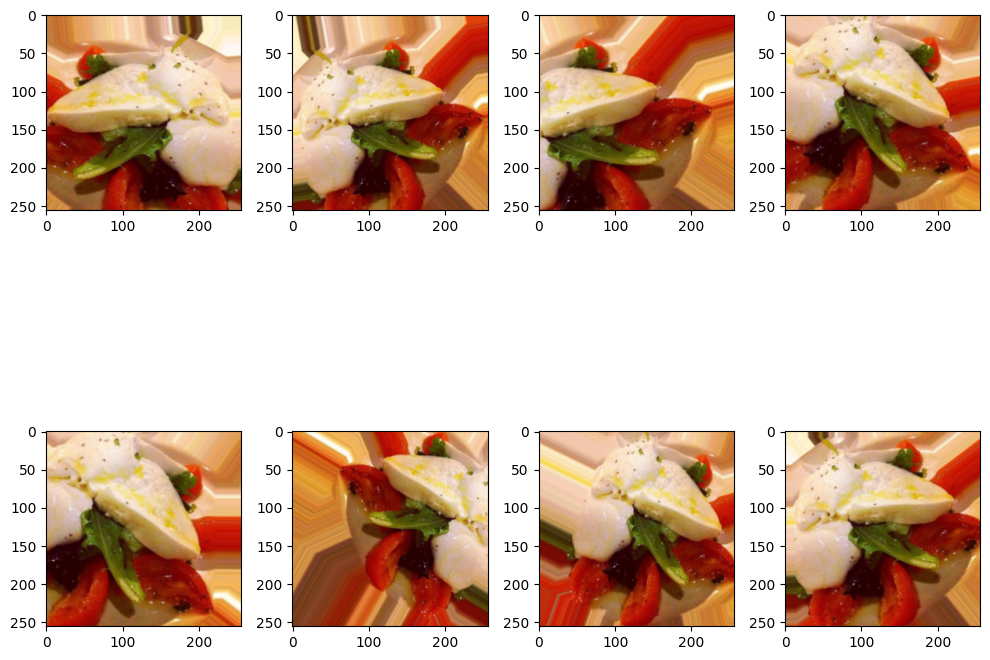

In [31]:
img, label = train_generator[0]
x = img[0]
x = x.reshape((1,) + x.shape) 

idx = 0
fig = plt.figure(figsize=(10, 10))
axs = []
for batch in train_datagen.flow(x, batch_size=1): # 여기서 batch는 x가 됨
    axs.append(fig.add_subplot(2, 4, idx+1))
    axs[idx].imshow(array_to_img(batch[0]))
    idx += 1
    if idx%8 == 0:
        break
fig.tight_layout()
plt.show()

### augmentation 시각화

In [3]:
file_path = "/Volumes/T7/food-101/train/apple_pie/"
x = os.listdir(file_path)
file_names=[]
for fn in x:
    if '.jpg' not in fn:
        continue
    else:
        file_names.append(fn)

for i in range(1):
    file_name = file_names[i]
    origin_image_path = file_path +  file_name
    x = Image.open(origin_image_path)

    x = img_to_array(x)
    x = x/255 

    grayscaled = tf.image.rgb_to_grayscale(x)
    saturated = tf.image.adjust_saturation(x, 3)
    bright = ImageEnhance.Brightness(array_to_img(x)).enhance(2.0)


    fig=plt.figure(figsize=(10,10))

    fig.add_subplot(141).imshow(x)
    fig.add_subplot(142).imshow(grayscaled)
    fig.add_subplot(143).imshow(saturated)
    fig.add_subplot(144).imshow(bright)

    plt.show()


IndexError: list index out of range